In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [3]:
#사이킷런에서는 20개의 다른 주제를 가진 18,846개의 뉴스 그룹 이메일 데이터를 제공합니다. (LSA 챕터와 동일한 데이터.)

newsdata=fetch_20newsgroups(subset='train') # 'train'을 기재하면 훈련 데이터만 리턴한다.
#위의 subset의 값으로 'all'을 넣으면 전체 데이터인 18,846개의 샘플을 다운로드할 수 있으며, 'train'을 넣으면 훈련 데이터를, 'test'를 넣으면 테스트 데이터를 다운로드할 수 있습니다. newsdata.keys()를 출력하면 해당 데이터의 속성을 확인할 수 있습니다.

In [4]:
print(newsdata.keys())


dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [5]:
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플의 개수 : 11314


In [6]:
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [14]:
newsdata.target[0]#타겟의 0번째 답은 인덱스7이다.

7

In [12]:
newsdata.target_names[7]#인덱스7의 주제는 autos

'rec.autos'

In [15]:
newsdata.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

이메일의 내용을 보니 스포츠 카에 대한 글로 보입니다. 이 글의 레이블은 7이고, 7번 레이블은 rec.autos란 주제를 의미합니다. 이제 훈련에 사용될 메일 본문인 data와 레이블인 target을 데이터프레임으로 만들어서 데이터에 대한 통계적인 정보들을 알아보겠습니다.

In [16]:
data = pd.DataFrame(newsdata.data, columns=['email']) # data로부터 데이터프레임 생성
data['target'] = pd.Series(newsdata.target) # target 열 추가
data[:5] # 상위 5개 행을 출력

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
email     11314 non-null object
target    11314 non-null int64
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


news열은 문자열, target열은 정수형 데이터입니다. 혹시 Null 값을 가진 샘플이 있는지 isnull().values.any()로도 확인 가능합니다.

In [18]:
data.isnull().values.any()

False

False는 데이터에 별도의 Null 값은 없음을 의미합니다. nunique()를 통해 샘플 중 중복을 제거한 개수를 확인할 수 있습니다.

In [19]:
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


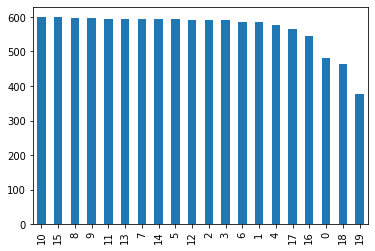

In [20]:
data['target'].value_counts().plot(kind='bar');

10번 레이블의 수가 가장 많고, 19번 레이블의 수가 가장 적으며 대체적으로 400 ~ 600개 사이의 분포를 보입니다. 이번에는 각 레이블이 몇 개 있는지 구체적인 수치로 확인해보겠습니다.

In [21]:
print(data.groupby('target').size().reset_index(name='count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


이제 데이터프레임으로부터 다시 메일 본문과 레이블을 분리하고, 테스트 데이터 또한 불러오겠습니다.

In [0]:
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True) # 'test'를 기재하면 테스트 데이터만 리턴한다.
train_email = data['email'] # 훈련 데이터의 본문 저장
train_label = data['target'] # 훈련 데이터의 레이블 저장
test_email = newsdata_test.data # 테스트 데이터의 본문 저장
test_label = newsdata_test.target # 테스트 데이터의 레이블 저장

In [0]:
max_words = 10000 # 실습에 사용할 단어의 최대 개수
num_classes = 20 # 레이블의 수

우선 필요한 변수들을 정의합니다. max_words는 이번 실습에서 사용할 최대 단어 개수를 정의하는 변수입니다. 뒤에서 케라스 토크나이저를 사용하면 빈도수 순으로 인덱스를 부여하므로, 빈도수가 가장 높은 상위 max_words 개수만큼의 단어를 사용합니다.

In [0]:
def prepare_data(train_data, test_data, mode): # 전처리 함수
    t = Tokenizer(num_words=max_words) # max_words 개수만큼의 단어만 사용한다.
    t.fit_on_texts(train_data)
    X_train = t.texts_to_matrix(train_data, mode=mode) # 샘플 수 × max_words 크기의 행렬 생성
    X_test = t.texts_to_matrix(test_data, mode=mode) # 샘플 수 × max_words 크기의 행렬 생성
    return X_train, X_test, t.index_word

케라스 토크나이저로 전처리를 수행하는 함수인 prepare_data를 만들었습니다. 해당 함수는 케라스 토크나이저를 통해 단어 토큰화를 수행하고, 앞서 배운 texts_to_matrix()를 사용하여 훈련 데이터와 테스트 데이터를 'binary', 'count', 'tfidf', 'freq' 4개의 모드 중 사용자가 정한 모드로 변환

In [0]:
X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary') # binary 모드로 변환
y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

메일 본문에 대해서는 'binary' 모드로 변환하고, 훈련 데이터와 테스트 데이터의 레이블은 원-핫 인코딩을 수행하였습니다.

In [26]:
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


훈련 데이터와 테스트 데이터 모두 메일 본문의 크기가 샘플의 수 × 10,000의 행렬로 변환되었는데, 열의 개수가 10,000인 것은 위의 prepard_data 함수 내부에서 Tokenizer의 num_words의 인자로 max_words를 지정해주었기 때문입니다. 사실 단어의 정수 인덱스는 1부터 시작하지만, 행렬의 인덱스는 0부터 시작하여 0번 인덱스는 사용되지 않으므로 실제로 행렬에는 빈도수 기준 상위 9,999개의 단어가 표현된 셈입니다. 빈도수 상위 1번 단어와 9,999번 단어를 확인해보겠습니다.

In [27]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


## 다층 퍼셉트론(Multilayer Perceptron, MLP)을 사용하여 텍스트 분류하기

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [0]:
def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(max_words,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]

코드로 돌아가보겠습니다. 위 모델에서는 과적합을 막기 위해서 두 번의 드롭아웃(Dropout)을 적용하였습니다. 이 문제는 다중 클래스 분류 문제입니다. 여러 개의 선택지 중에서 하나의 선택지를 고르는 문제인데, 이 경우 20개의 주제 중에서 모델은 자신이 정답이라고 생각하는 1개의 주제를 예측해야 합니다. 다중 클래스 분류 문제이므로 출력층의 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로는 크로스 엔트로피(categorical_crossentropy) 함수를 사용하였습니다.

모델을 훈련시켜보겠습니다. 이번에는 앞서 배운 texts_to_matrix()의 4개의 모드에 대해서 전부 모델의 결과를 확인해보겠습니다.

In [0]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
    X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련하고 평가.
    print(mode+' 모드의 테스트 정확도:', score)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 4s 416us/sample - loss: 2.2599 - acc: 0.3539 - val_loss: 0.9618 - val_acc: 0.8348
Epoch 2/5
10182/10182 [==============================] - 4s 375us/sample - loss: 0.8791 - acc: 0.7673 - val_loss: 0.4512 - val_acc: 0.8869
Epoch 3/5
10182/10182 [==============================] - 4s 367us/sample - loss: 0.4326 - acc: 0.8877 - val_loss: 0.3427 - val_acc: 0.9064
Epoch 4/5
10182/10182 [==============================] - 4s 367us/sample - loss: 0.2588 - acc: 0.9354 - val_loss: 0.3017 - val_acc: 0.9170
Epoch 5/5
10182/10182 [==============================] - 4s 364us/sample - loss: 0.1693 - acc: 0.9582 - val_loss: 0.2964 - val_acc: 0.9170
binary 모드의 테스트 정확도: 0.8278014
Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 4s 388us/sample - loss: 2.8113 - acc: 0